```
From: https://github.com/ksatola
Version: 0.0.1

TODOs
https://github.com/ResidentMario/missingno
1. Advanced imputing: https://scikit-learn.org/stable/modules/impute.html

```

# Missing Data

We need to deal with missing data as most algorithms will not work if data is missing. Notable exceptions are the recent boosting libraries: XGBoost, CatBoost, and LightGBM. There are no hard answers for how to treat missing data. Also, missing data could represent different situations.

There are various ways to handle missing data:
- Remove any row with missing data,
- Remove any column with missing data,
- Impute missing values,
- Create an indicator column to signify data was missing.



In [2]:
# Connect with underlying Python code
%load_ext autoreload
%autoreload 2
import sys
sys.path.insert(0, '../src')

In [3]:
from datasets import (
    get_dataset
)

In [4]:
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
df = get_dataset('titanic3')

## Examine Missing Data

In [6]:
# Get percent of missing data per column
df.isnull().mean() * 100

pclass        0.000000
survived      0.000000
name          0.000000
sex           0.000000
age          20.091673
sibsp         0.000000
parch         0.000000
ticket        0.000000
fare          0.076394
cabin        77.463713
embarked      0.152788
boat         62.872422
body         90.756303
home.dest    43.086325
dtype: float64

In [7]:
# Show percent of missing values per row (limit to 10 with the highest rate)
(df.isnull().mean(axis=1) * 100).sort_values(ascending=False)[:10]

1005    35.714286
815     35.714286
835     35.714286
1073    35.714286
1074    35.714286
842     35.714286
1186    35.714286
1185    35.714286
1184    35.714286
843     35.714286
dtype: float64

To visualize patterns in the missing data, use the `missingno` library. This library is useful for viewing contiguous areas of missing data, which would indicate that the missing data is not random. The matrix function includes a sparkline along the right side. Patterns here would also indicate nonrandom missing data. You may need to limit the number of samples to be able to see the patterns.

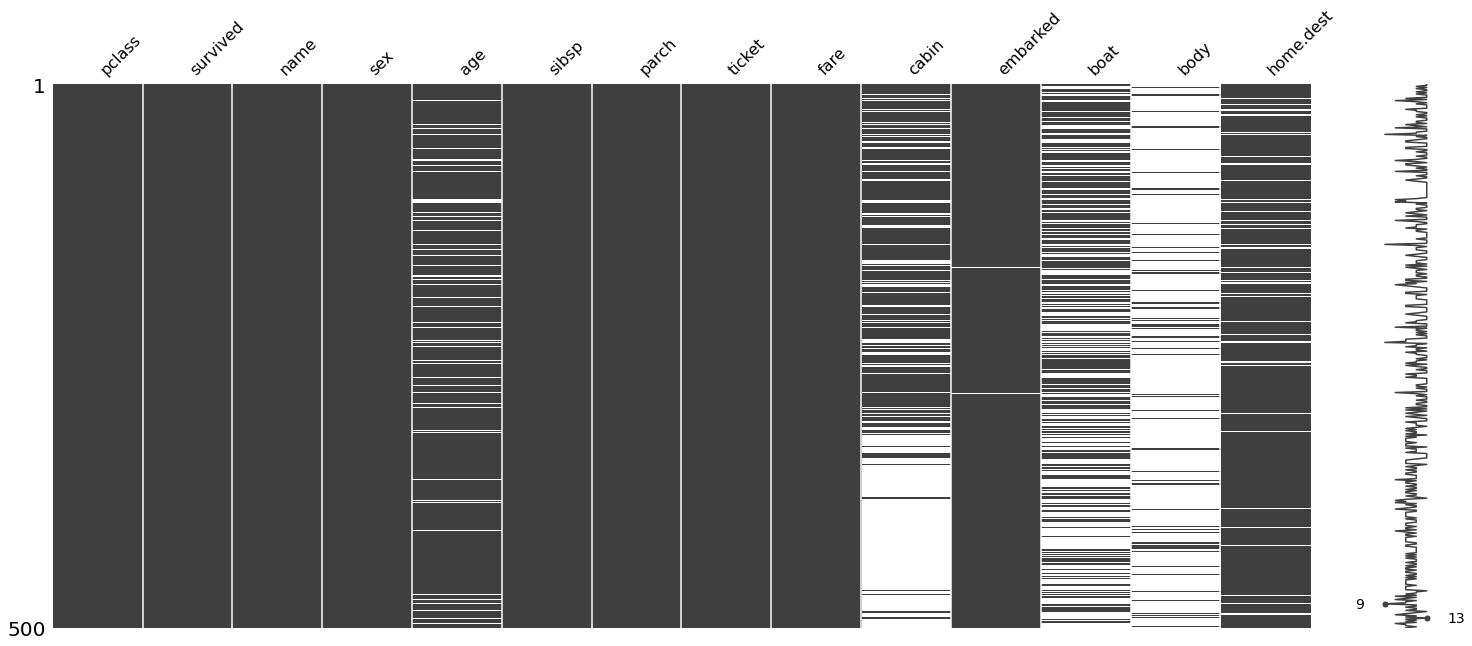

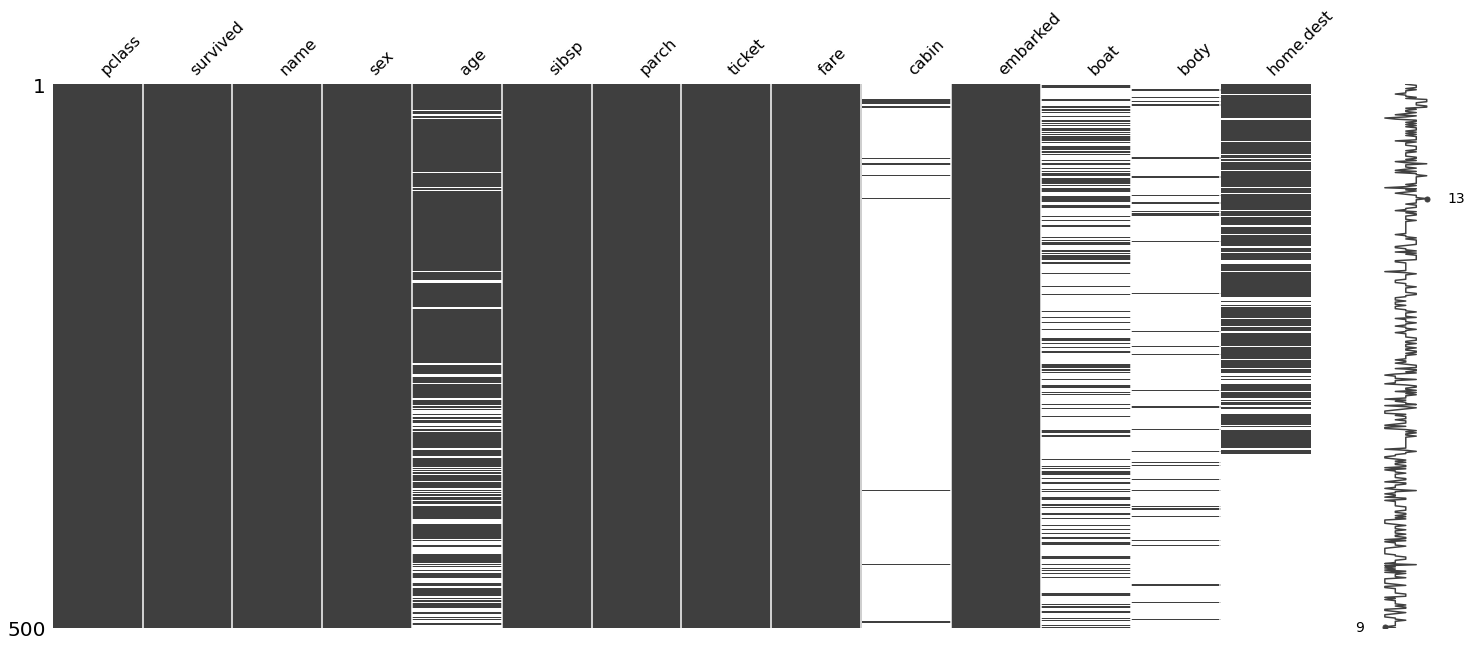

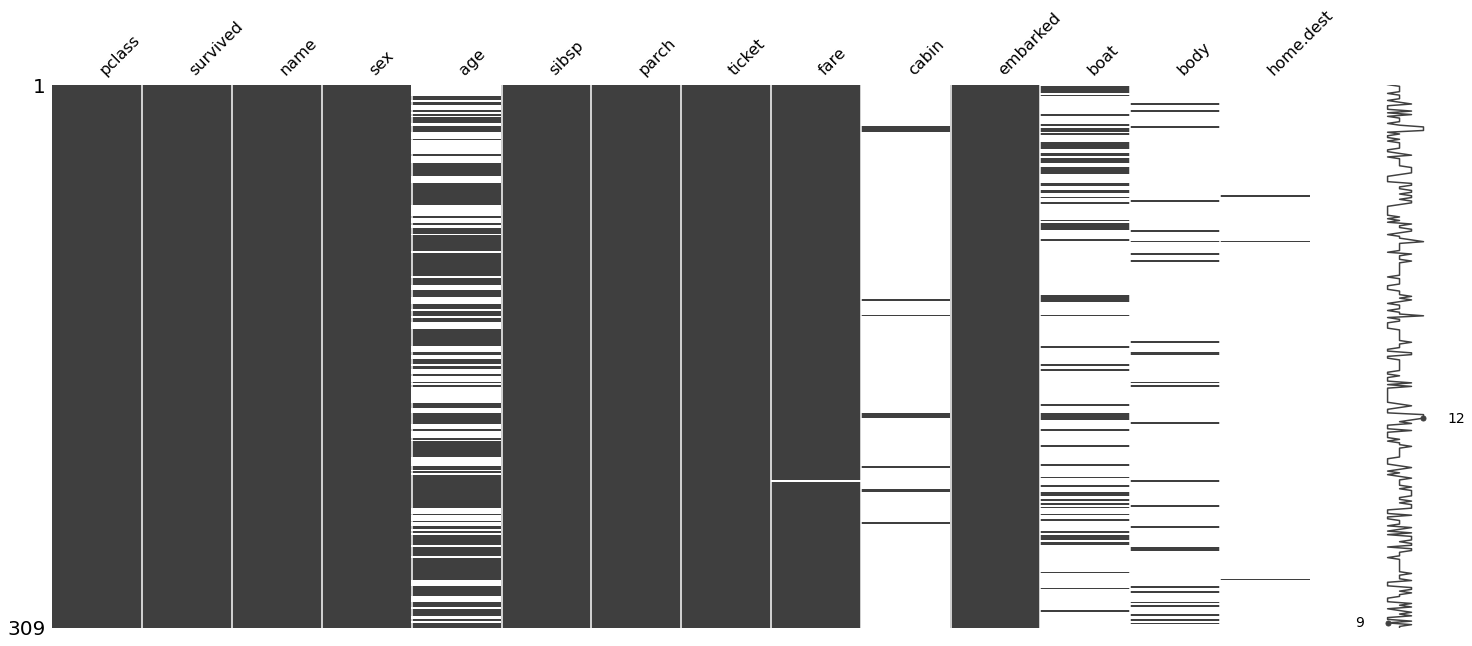

In [8]:
import missingno as msno
#ax = msno.matrix(df.sample(500))
ax = msno.matrix(df[:500])
ax = msno.matrix(df[500:1000])
ax = msno.matrix(df[1000:])
ax.get_figure().savefig("../images/missing_values_patterns.png")

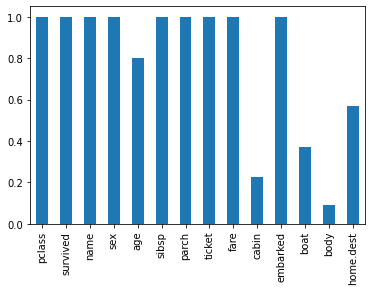

In [9]:
# Create a bar plot of missing data counts
fig, ax = plt.subplots(figsize=(6, 4))
(1 - df.isnull().mean()).abs().plot.bar(ax=ax)
fig.savefig("../images/missing_values_bar_plot1.png", dpi=300)

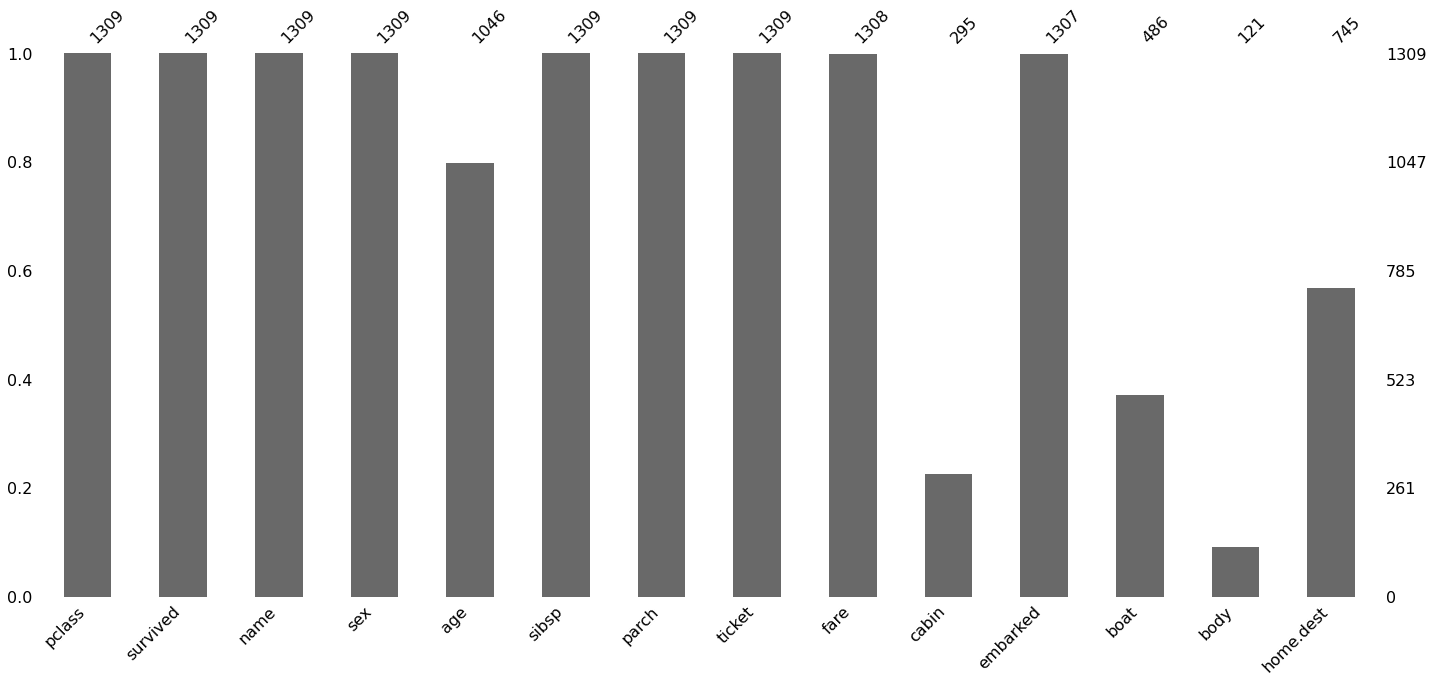

In [10]:
ax = msno.bar(df)
ax.get_figure().savefig("../images/missing_values_bar_plot2.png")

Create a heat map showing if there are correlations where data is missing. In this case, it doesn’t look like the locations where data are missing are correlated

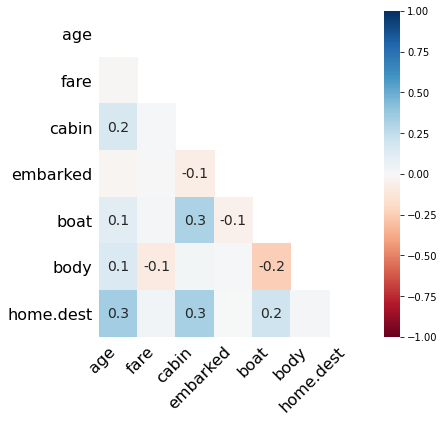

In [11]:
ax = msno.heatmap(df, figsize=(6, 6))
ax.get_figure().savefig("../images/missing_values_heatmap.png")

We can create a dendrogram showing the clusterings of where data is missing. Leaves that are at the same level predict one another’s presence (empty or filled). The vertical arms are used to indicate how different clusters are. Short arms mean that branches are similar. We can see the columns without missing data on the upper right.

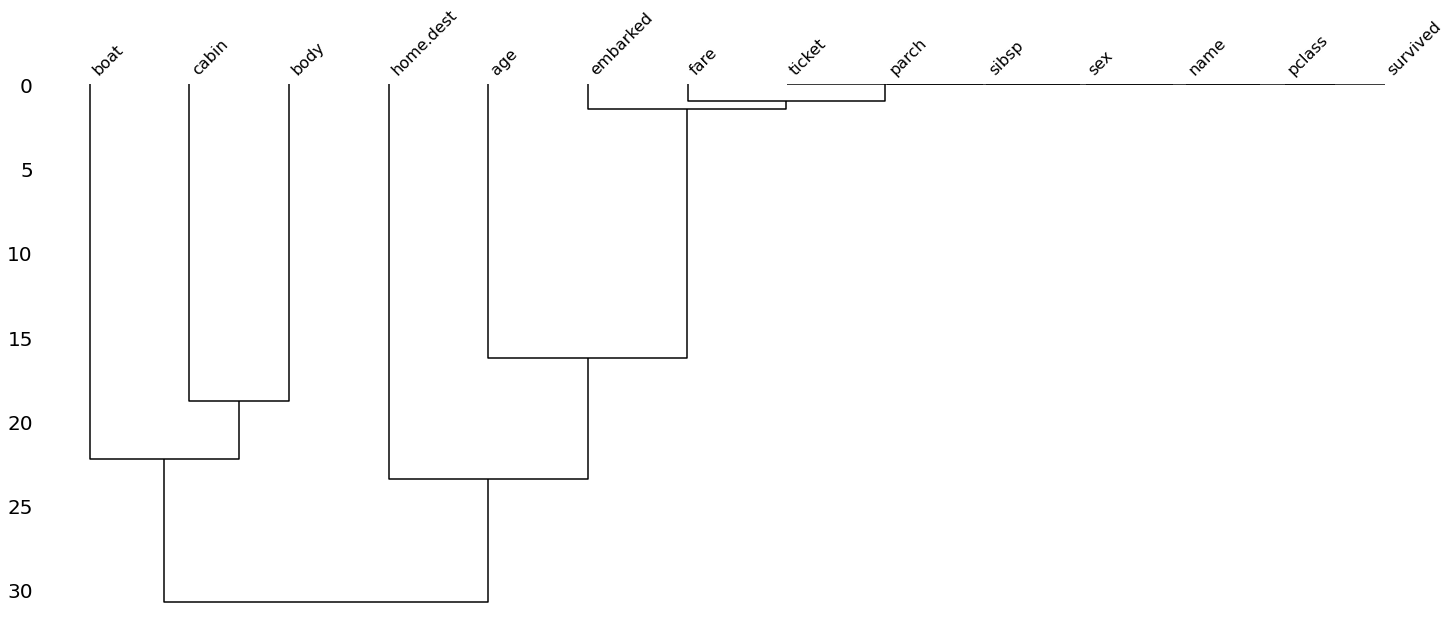

In [12]:
ax = msno.dendrogram(df)
ax.get_figure().savefig("../images/missing_values_dendrogram.png")

## Drop Missing Data
Be careful about dropping data. Typically this should be a last resort option.

In [13]:
# Drop all rows with missing data
print(df.shape)
df1 = df.dropna()
print(df1.shape)

(1309, 14)
(0, 14)


In [14]:
# Drop along the column axis
print(df.shape)
df1 = df.dropna(axis=1)
print(df1.shape)

(1309, 14)
(1309, 7)


In [15]:
# Drop columns
print(df.shape)
df1 = df.drop(columns="cabin")
print(df1.shape)

(1309, 14)
(1309, 13)


## Impute Data
Once you have a tool for predicting data, you can use that to predict missing data. The general task of defining values for missing values is called `imputation`.

If you are imputing data, you will need to build up a pipeline and use the same imputation logic during model creation and prediction time. The `SimpleImputer` class in scikit-learn will handle mean, median, and most frequent feature values.

You can use the `.fillna` method in pandas to impute missing values as well. Make sure that you do not leak data though. If you are filling in with the `mean` value, make sure you use the same mean value during model creation and model prediction time.

In [16]:
# Calculate the mean
from sklearn.impute import SimpleImputer

num_cols = df.select_dtypes(include="number").columns
im = SimpleImputer()  # mean
imputed = im.fit_transform(df[num_cols])

In [17]:
imputed

array([[  1.        ,   1.        ,  29.        , ...,   0.        ,
        211.3375    , 160.80991736],
       [  1.        ,   1.        ,   0.9167    , ...,   2.        ,
        151.55      , 160.80991736],
       [  1.        ,   0.        ,   2.        , ...,   2.        ,
        151.55      , 160.80991736],
       ...,
       [  3.        ,   0.        ,  26.5       , ...,   0.        ,
          7.225     , 304.        ],
       [  3.        ,   0.        ,  27.        , ...,   0.        ,
          7.225     , 160.80991736],
       [  3.        ,   0.        ,  29.        , ...,   0.        ,
          7.875     , 160.80991736]])

In [18]:
# Median, most frequent value, constant
num_cols = df.select_dtypes(include="number").columns
#im = SimpleImputer(strategy='median')
#im = SimpleImputer(strategy='most_frequent')
im = SimpleImputer(strategy='constant', fill_value=-1)
imputed = im.fit_transform(df[num_cols])

The `most frequent` and `constant` strategies may be used with numeric or string data. The `mean` and `median` require numeric data.

In [19]:
imputed

array([[  1.    ,   1.    ,  29.    , ...,   0.    , 211.3375,  -1.    ],
       [  1.    ,   1.    ,   0.9167, ...,   2.    , 151.55  ,  -1.    ],
       [  1.    ,   0.    ,   2.    , ...,   2.    , 151.55  ,  -1.    ],
       ...,
       [  3.    ,   0.    ,  26.5   , ...,   0.    ,   7.225 , 304.    ],
       [  3.    ,   0.    ,  27.    , ...,   0.    ,   7.225 ,  -1.    ],
       [  3.    ,   0.    ,  29.    , ...,   0.    ,   7.875 ,  -1.    ]])

In [20]:
df1.loc[:, num_cols] = imputed
print(df1.isnull().mean() * 100)
df1.head()

pclass        0.000000
survived      0.000000
name          0.000000
sex           0.000000
age           0.000000
sibsp         0.000000
parch         0.000000
ticket        0.000000
fare          0.000000
embarked      0.152788
boat         62.872422
body          0.000000
home.dest    43.086325
dtype: float64


,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,embarked,boat,body,home.dest
0,1.0,1.0,"Allen, Miss. Elisabeth Walton",female,29.0000,0.0,0.0,24160,211.3375,S,2,-1.0,"St Louis, MO"
1,1.0,1.0,"Allison, Master. Hudson Trevor",male,0.9167,1.0,2.0,113781,151.5500,S,11,-1.0,"Montreal, PQ / Chesterville, ON"
2,1.0,0.0,"Allison, Miss. Helen Loraine",female,2.0000,1.0,2.0,113781,151.5500,S,NaN,-1.0,"Montreal, PQ / Chesterville, ON"
3,1.0,0.0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1.0,2.0,113781,151.5500,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1.0,0.0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1.0,2.0,113781,151.5500,S,NaN,-1.0,"Montreal, PQ / Chesterville, ON"


The `fancyimpute` library implements many algorithms and follows the `scikit-learn` interface. Sadly, most of the algorithms are transductive, meaning that you can’t call the `.transform` method by itself after fitting the algorithm. The `IterativeImputer` is inductive (has since been migrated from fancyimpute to `scikit-learn`) and supports transforming after fitting.

In [55]:
# TODO: https://scikit-learn.org/stable/modules/impute.html

## Impute Data using MissForest

In [30]:
df.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


In [31]:
df.isna().sum(axis=0)

pclass          0
survived        0
name            0
sex             0
age           263
sibsp           0
parch           0
ticket          0
fare            1
cabin        1014
embarked        2
boat          823
body         1188
home.dest     564
dtype: int64

In [32]:
df1 = df.copy()
df1.drop(columns=['cabin', 'boat', 'body', 'home.dest'], inplace=True)

In [35]:
df1.columns

Index(['pclass', 'survived', 'name', 'sex', 'age', 'sibsp', 'parch', 'ticket',
       'fare', 'embarked'],
      dtype='object')

In [42]:
cols_to_input = ['pclass', 'survived', 'age', 'sibsp', 'parch', 'fare']

In [43]:
from missingpy import MissForest

imputer = MissForest(max_iter=15, n_estimators=200, n_jobs=-1, random_state=250)
df1 = imputer.fit_transform(df1[cols_to_input])

Iteration: 0
Iteration: 1
Iteration: 2


In [47]:
df1_df = pd.DataFrame(data=df1, index=df.index, columns=cols_to_input)
df1_df.head()

,pclass,survived,age,sibsp,parch,fare
0,1.0,1.0,29.0000,0.0,0.0,211.3375
1,1.0,1.0,0.9167,1.0,2.0,151.5500
2,1.0,0.0,2.0000,1.0,2.0,151.5500
3,1.0,0.0,30.0000,1.0,2.0,151.5500
4,1.0,0.0,25.0000,1.0,2.0,151.5500


In [48]:
df1_df.isna().sum(axis=0)

pclass      0
survived    0
age         0
sibsp       0
parch       0
fare        0
dtype: int64

In [53]:
cols_to_add = ['name', 'sex', 'embarked']
df_final = pd.concat([df1_df, df[cols_to_add]], axis=1)
df_final.head()

,pclass,survived,age,sibsp,parch,fare,name,sex,embarked
0,1.0,1.0,29.0000,0.0,0.0,211.3375,"Allen, Miss. Elisabeth Walton",female,S
1,1.0,1.0,0.9167,1.0,2.0,151.5500,"Allison, Master. Hudson Trevor",male,S
2,1.0,0.0,2.0000,1.0,2.0,151.5500,"Allison, Miss. Helen Loraine",female,S
3,1.0,0.0,30.0000,1.0,2.0,151.5500,"Allison, Mr. Hudson Joshua Creighton",male,S
4,1.0,0.0,25.0000,1.0,2.0,151.5500,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,S


In [56]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   pclass    1309 non-null   float64
 1   survived  1309 non-null   float64
 2   age       1309 non-null   float64
 3   sibsp     1309 non-null   float64
 4   parch     1309 non-null   float64
 5   fare      1309 non-null   float64
 6   name      1309 non-null   object 
 7   sex       1309 non-null   object 
 8   embarked  1307 non-null   object 
dtypes: float64(6), object(3)
memory usage: 92.2+ KB


In [58]:
df_final.dropna(axis='index', inplace=True)

In [59]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1307 entries, 0 to 1308
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   pclass    1307 non-null   float64
 1   survived  1307 non-null   float64
 2   age       1307 non-null   float64
 3   sibsp     1307 non-null   float64
 4   parch     1307 non-null   float64
 5   fare      1307 non-null   float64
 6   name      1307 non-null   object 
 7   sex       1307 non-null   object 
 8   embarked  1307 non-null   object 
dtypes: float64(6), object(3)
memory usage: 102.1+ KB


## Add Indicator Columns
The lack of data in and of itself may provide some signal to a model. The pandas library can add a new column to indicate that a value was missing.

In [49]:
def add_indicator(col):
    return df[col].isna().astype(int)

df1 = df.assign(cabin_missing=add_indicator("cabin"))

In [50]:
df1.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest,cabin_missing
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO",0
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON",0
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON",0
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON",0
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON",0


In [51]:
df1['cabin'].isna().sum()

1014

In [52]:
df1['cabin_missing'].value_counts()

1    1014
0     295
Name: cabin_missing, dtype: int64